# Task 4 — Forecasting Access and Digital Payment Usage (2025-2027)

This notebook reproduces the forecasting pipeline: it loads the prepared Excel (`data/processed/ethiopia_fi_unified_data_enriched.xlsx`), explores the `Account Ownership Rate` and a digital-payments proxy, fits trend and logit-trend models, performs scenario analysis (baseline, optimistic, pessimistic, event-augmented), and writes `reports/forecasts_task4.csv`.

Limitations: sparse Findex survey points (2014,2017,2021,2024) — treat results as indicative ranges, not precise predictions.

In [1]:
# Imports and plotting settings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load unified enriched workbook and show candidate indicators
path = Path('../data/processed/ethiopia_fi_unified_data_enriched.xlsx')
df = pd.read_excel(path, sheet_name='ethiopia_fi_unified_data')
inds = sorted(set(df['indicator'].dropna().astype(str).tolist()))
[i for i in inds if any(k in i.lower() for k in ['account','payment','mobile','digital'])][:30]

['Account Ownership Gender Gap',
 'Account Ownership Rate',
 'EthioPay Instant Payment System Launch',
 'Fayda Digital ID Enrollment',
 'Fayda Digital ID Program Rollout',
 'Female Mobile Money Account Share',
 'Gender Gap in Account Ownership',
 'Mobile Internet Penetration',
 'Mobile Money Account Rate',
 'Mobile Money Activity Rate',
 'Mobile Money Agent Density',
 'Mobile Phone Gender Gap',
 'Mobile Subscription Penetration',
 'P2P Digital Payment Transaction Volume',
 'QR Code Payment Standard Launch']

In [3]:
# Helper functions: logit transform and simple OLS-based trend with approximate prediction SEs
def safe_logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))
def safe_inv_logit(x):
    return 1.0 / (1.0 + np.exp(-x))
def fit_linear(years, y):
    X = np.vstack([np.ones_like(years), years]).T
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X.dot(beta)
    resid = y - y_hat
    s2 = (resid ** 2).sum() / max(1, (len(y) - X.shape[1]))
    XtX_inv = np.linalg.pinv(X.T.dot(X))
    return {'beta': beta, 's2': s2, 'XtX_inv': XtX_inv}
def predict_linear(model, years_pred):
    Xp = np.vstack([np.ones_like(years_pred), years_pred]).T
    y_pred = Xp.dot(model['beta'])
    se = np.sqrt(np.array([model['s2'] * (1 + x.dot(model['XtX_inv']).dot(x)) for x in Xp]))
    return y_pred, se
def fit_logit_linear(years, y_pct):
    p = np.clip(y_pct / 100.0, 1e-6, 1 - 1e-6)
    z = safe_logit(p)
    return fit_linear(years, z)
def predict_logit_linear(model, years_pred):
    z_pred, se_z = predict_linear(model, years_pred)
    p_pred = safe_inv_logit(z_pred)
    se_p = se_z * (p_pred * (1 - p_pred))
    return p_pred * 100.0, se_p * 100.0

In [4]:
# Extract series helper (prefer Global Findex rows)
def select_findex(df, indicator_name):
    sub = df[df['indicator'] == indicator_name].copy()
    g = sub[sub['source_name'].str.contains('Global Findex', na=False)]
    sel = g if not g.empty else sub
    sel = sel.dropna(subset=['fiscal_year'])
    sel = sel.groupby('fiscal_year', as_index=False).agg({'value_numeric': 'max'})
    sel = sel.sort_values('fiscal_year')
    return sel['fiscal_year'].astype(int).values, sel['value_numeric'].values
years_acc, vals_acc = select_findex(df, 'Account Ownership Rate')
print('Account Ownership data:')
print(list(zip(years_acc, vals_acc)))
years_mm, vals_mm = select_findex(df, 'Mobile Money Account Rate')
if len(years_mm) == 0:
    years_mm, vals_mm = select_findex(df, 'Mobile Money Activity Rate')
print('Digital proxy data:')
print(list(zip(years_mm, vals_mm)))

Account Ownership data:
[(np.int64(2014), np.float64(22.0)), (np.int64(2017), np.float64(35.0)), (np.int64(2021), np.float64(56.0)), (np.int64(2024), np.float64(49.0))]
Digital proxy data:
[(np.int64(2021), np.float64(4.7)), (np.int64(2024), np.float64(9.45))]


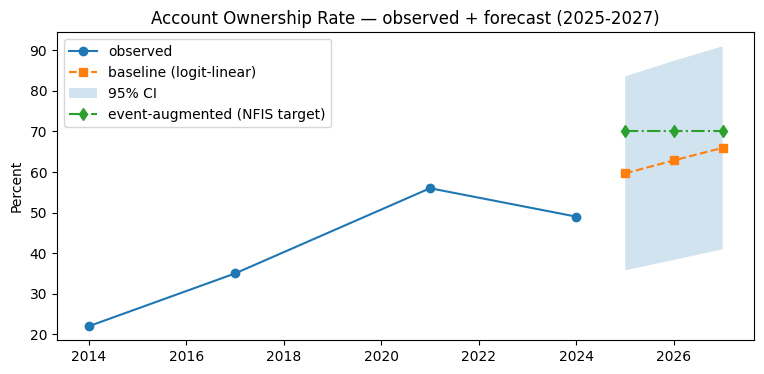

In [5]:
# Fit logit-linear baseline and forecast 2025-2027 with CIs; also create simple event-augmented paths if targets/events exist
years_fore = np.array([2025, 2026, 2027])
logit_acc = fit_logit_linear(years_acc, vals_acc)
acc_pred, acc_se = predict_logit_linear(logit_acc, years_fore)
logit_mm = fit_logit_linear(years_mm, vals_mm)
mm_pred, mm_se = predict_logit_linear(logit_mm, years_fore)
nfis = df[(df['indicator'] == 'Account Ownership Rate') & (df['source_name'].str.contains('NFIS', na=False))]
event_acc = None
if not nfis.empty:
    target_row = nfis.sort_values('fiscal_year').iloc[-1]
    target_year = int(target_row['fiscal_year'])
    target_val = float(target_row['value_numeric'])
    last_year = max(years_acc)
    last_val = float(vals_acc[years_acc.argmax()])
    def event_path(y):
        if y <= last_year:
            return last_val
        elif y >= target_year:
            return target_val
        else:
            frac = (y - last_year) / (target_year - last_year)
            return last_val + frac * (target_val - last_val)
    event_acc = np.array([event_path(y) for y in years_fore])
opt_acc = acc_pred + 1.5 * acc_se
pess_acc = acc_pred - 1.5 * acc_se
opt_mm = mm_pred + 1.5 * mm_se
pess_mm = mm_pred - 1.5 * mm_se
plt.figure(figsize=(9,4))
plt.plot(years_acc, vals_acc, 'o-', label='observed')
plt.plot(years_fore, acc_pred, 's--', label='baseline (logit-linear)')
plt.fill_between(years_fore, acc_pred - 1.96 * acc_se, acc_pred + 1.96 * acc_se, alpha=0.2, label='95% CI')
if event_acc is not None:
    plt.plot(years_fore, event_acc, 'd-.', label='event-augmented (NFIS target)')
plt.title('Account Ownership Rate — observed + forecast (2025-2027)')
plt.ylabel('Percent')
plt.legend()
plt.show()

### Save forecasts to CSV for dashboard use
The file `reports/forecasts_task4.csv` will be written and can be consumed by the dashboard app or the Task 5 notebook.

In [6]:
# Assemble and save forecast table
rows = []
for i, y in enumerate(years_fore):
    rows.append({'series': 'Account Ownership Rate', 'year': int(y), 'baseline': float(acc_pred[i]), 'ci95_low': float(acc_pred[i] - 1.96 * acc_se[i]), 'ci95_high': float(acc_pred[i] + 1.96 * acc_se[i]), 'optimistic': float(opt_acc[i]), 'pessimistic': float(pess_acc[i]), 'event_augmented': float(event_acc[i]) if event_acc is not None else None})
    rows.append({'series': 'Digital Payment Usage (proxy)', 'year': int(y), 'baseline': float(mm_pred[i]), 'ci95_low': float(mm_pred[i] - 1.96 * mm_se[i]), 'ci95_high': float(mm_pred[i] + 1.96 * mm_se[i]), 'optimistic': float(opt_mm[i]), 'pessimistic': float(pess_mm[i]), 'event_augmented': None})
out = pd.DataFrame(rows)
outdir = Path('../reports')
outdir.mkdir(parents=True, exist_ok=True)
out.to_csv(outdir / 'forecasts_task4.csv', index=False)
print('Wrote', outdir / 'forecasts_task4.csv')

Wrote ..\reports\forecasts_task4.csv
